In [21]:
import os
import pandas as pd
import requests
import time
import random
import matplotlib.pyplot as plt
import re

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [22]:
RANDOM_SEED = 1
tf.random.set_seed(RANDOM_SEED)

# 1. Data Processing

## 1.1. Data Retrieval

In [2]:
WEB_DRIVER_DELAY_TIME_INT = 10

In [3]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.headless = True

driver = webdriver.Chrome('chromedriver', options=chrome_options)
driver.implicitly_wait(4)

wait = WebDriverWait(driver, WEB_DRIVER_DELAY_TIME_INT)

C:\Users\ABC\AppData\Local\Temp\ipykernel_14552\3479716814.py:4: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
  chrome_options.headless = True


In [18]:
datasets = []
deletion_script = 'arguments[0].parentNone.removeChild(arguments[0]);'

for page_idx in tqdm(range(1, 11)):
    main_url = f'https://www.thivien.net/searchpoem.php?PoemType=16&ViewType=1&Country=2&Age[]=3&Page={page_idx}'
    driver.get(main_url)

    content_tags_xpath = '//*[@id="PageContent"]/div[2]/div/div[@class="list-item"]'
    content_tags = driver.find_elements(By.XPATH, content_tags_xpath)

    for idx in range(len(content_tags)):
        content_tag_xpath = f'/html/body/div[4]/div[2]/div/div[{2+idx}]'
        content_title_xpath = f'/html/body/div[4]/div[2]/div/div[{2+idx}]/h4/a'

        content_tag = wait.until(EC.presence_of_element_located((By.XPATH, content_tag_xpath)))
        poem_title = wait.until(EC.presence_of_element_located((By.XPATH, content_title_xpath))).text
        poem_url = wait.until(EC.presence_of_element_located((By.XPATH, content_title_xpath))).get_attribute('href')

        try:
            driver.get(poem_url)
            poem_src_path = '//span[@class="small"]'
            poem_content_tag = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'poem-content')))

            try:
                poem_content_i_tag = poem_content_tag.find_element(By.TAG_NAME, 'i')
                driver.execute_script(deletion_script, poem_content_i_tag)
            except:
                pass

            try:
                poem_content_b_tag = poem_content_tag.find_element(By.TAG_NAME, 'b')
                driver.execute_script(deletion_script, poem_content_b_tag)
            except:
                pass
            poem_content = poem_content_tag.text

            try:
                poem_src_tag = wait.until(EC.presence_of_element_located((By.XPATH, poem_src_tag)))
                poem_src = poem_src_tag.text
            except:
                poem_src = ''

            poem_info = {
                'title': poem_title, 
                'content': poem_content, 
                'source': poem_src, 
                'url': poem_url
            }
            datasets.append(poem_info)
            driver.back()
        except Exception as e:
            print(e)
            print(poem_url)


100%|██████████| 10/10 [17:28<00:00, 104.87s/it]


In [20]:
df = pd.DataFrame(datasets)
df.to_csv(r'C:\Users\ABC\Desktop\AIO-Project\Text Generation\data\poem_dataset.csv', index=True)

## 1.2. Clean and Process data for training

In [23]:
DATA_PATH = './data/poem_dataset.csv'
df = pd.read_csv(DATA_PATH, index_col=0)
df.head(10)

,title,content,source,url
0,“Cái làm ta hạnh phúc”,Cái làm ta hạnh phúc\nThực ra cũng chẳng nhiều...,NaN,https://www.thivien.net/Th%C3%A1i-B%C3%A1-T%C3...
1,“Chiều vừa xốp trên tay”,Chiều vừa xốp trên tay\nChợt nghe thoáng ong b...,NaN,https://www.thivien.net/L%C3%A2m-Huy-Nhu%E1%BA...
2,“Dưới giàn hoa thiên lý...”,Dưới giàn hoa thiên lý\nMột mình anh đang ngồi...,NaN,https://www.thivien.net/Nguy%E1%BB%85n-Nh%E1%B...
3,"“Đến, nhiều nơi để đến”","Đến, nhiều nơi để đến\nVề, trở lại với mình\nC...",NaN,https://www.thivien.net/Th%C3%A1i-B%C3%A1-T%C3...
4,“Đừng bao giờ dại dột”,Đừng bao giờ dại dột\nĐem chuyện riêng của mìn...,NaN,https://www.thivien.net/Th%C3%A1i-B%C3%A1-T%C3...
5,“Hầu hết các đồ vật”,Hầu hết các đồ vật\nTa muốn đều đắt tiền\nMột ...,NaN,https://www.thivien.net/Th%C3%A1i-B%C3%A1-T%C3...
6,“Hoàng thị” chưa quên…,Chưa hết mùa tầm xuân\nNên mưa còn ngại ngần\n...,NaN,https://www.thivien.net/Minh-S%C6%A1n-L%C3%AA/...
7,“Khi cô gái im lặng”,"Khi cô gái im lặng\nNăm lý do như sau:\nMột, n...",NaN,https://www.thivien.net/Th%C3%A1i-B%C3%A1-T%C3...
8,“Khi tiếng niệm Di Đà”,Khi tiếng niệm Di Đà\nVang vọng trong tâm ta\n...,NaN,https://www.thivien.net/Th%C3%ADch-Ch%C3%A2n-T...
9,“Khoẻ - không phải nhấc mạnh”,Khoẻ - không phải nhấc mạnh\nMà biết đặt nhẹ n...,NaN,https://www.thivien.net/Th%C3%A1i-B%C3%A1-T%C3...


In [24]:
def text_normalize(text):
    text = text.lower()
    text = text.strip()
    text = re.sub(r'[^\w\s\n]', '', text)
    text = text.replace('\n\n', '\n')
    text = '\n'.join(['<start>' + line + '<end>' for line in text.split('\n') 
                      if line!='' and len(line.split())==5])
    return text

df['content'] = df['content'].apply(lambda p: text_normalize(p))
corpus = df['content'].to_numpy()

In [25]:
X = []
y = []

for idx, row in df.iterrows():
    lines = row['content'].split('\n')
    lines = [line for line in lines if line!=' ']
    for idx in range(0, len(lines) -1):
        input_sentence = lines[idx]
        output_sentence = lines[idx+1]

        X.append(input_sentence)
        y.append(output_sentence)


In [30]:
# Tokenization
VOCAB_SIZE = 50000

tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters=' ', oov_token='<OOV>')
tokenizer.fit_on_texts(corpus)

VOCAB_SIZE = len(tokenizer.word_index) + 1

In [31]:
# Padding

MAX_SEQ_LEN = 7
X_sequences = tokenizer.texts_to_sequences(X)
X_padded_sequences = pad_sequences(X_sequences, maxlen=MAX_SEQ_LEN, 
                                   truncating='pre', padding='post')

In [33]:
def prepare_output_sequence(y_sequence):
    y_inputs = pad_sequences([y_seq[:-1] for y_seq in y_sequence], maxlen=MAX_SEQ_LEN, 
                             truncating='pre', padding='post')
    y_outputs = pad_sequences([y_seq[1:] for y_seq in y_sequence], maxlen=MAX_SEQ_LEN,
                              truncating='pre', padding='post')
    return y_inputs, y_outputs

y_sequences = tokenizer.texts_to_sequences(y)
y_inputs, y_outputs = prepare_output_sequence(y_sequences)

In [34]:
n_samples = len(X_padded_sequences)
train_len = int(n_samples*0.7)
val_len = int(n_samples*0.2)
test_len = n_samples - train_len - val_len

# Shuffle
import numpy as np
np.random.seed(1)
idxs = np.arange(n_samples)
idxs = np.random.permutation(idxs)

X_padded_sequences = X_padded_sequences[idxs]
y_inputs = y_inputs[idxs]
y_outputs = y_outputs[idxs]

# Splitting dataset into train/val/test
X_train_seq, y_train_input, y_train_output = X_padded_sequences[:train_len], y_inputs[:train_len], y_outputs[:train_len]
X_val_seq, y_val_input, y_val_output = X_padded_sequences[train_len:train_len+val_len], y_inputs[train_len:train_len+val_len], y_outputs[train_len:train_len+val_len]
X_test_seq, y_test_input, y_test_output = X_padded_sequences[train_len+val_len:], y_inputs[train_len+val_len:], y_outputs[train_len+val_len:]


In [35]:
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices(((X_train_seq, y_train_input), y_train_output)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices(((X_val_seq, y_val_input), y_val_output)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices(((X_test_seq, y_test_input), y_test_output)).batch(BATCH_SIZE)

In [36]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 2. Model Implementation

In [37]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :]/depth

    angle_rates = 1/(10000**depths)
    angle_rads = positions * angle_rates

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)], axis=-1
    )

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)
    
    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [50]:
# ATTENTION MECHANISM

class BaseAttention(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = keras.layers.MultiHeadAttention(**kwargs)
        self.layer_norm = keras.layers.LayerNormalization()
        self.add = keras.layers.Add()

class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(query=x, key=context, value=context, 
                                            return_attention_scores=True)
        self.last_attn_scores = attn_scores
        x = self.add([x, attn_output])
        x = self.layer_norm(x)
        return x
    
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query=x, key=x, value=x)
        x = self.add([x, attn_output])
        x = self.layer_norm(x)
        return x
    
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query=x, key=x, value=x)
        x = self.add([x, attn_output])
        x = self.layer_norm(x)
        return x

In [51]:
class FeedForward(keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = keras.Sequential([
            keras.layers.Dense(dff, activation='relu'), 
            keras.layers.Dense(d_model), 
            keras.layers.Dropout(dropout_rate)
        ])
        self.add = keras.layers.Add()
        self.layer_norm = keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

In [52]:
# ENCODER

class EncoderLayer(keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads, 
            key_dim=d_model, 
            dropout=dropout_rate
        )
        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x
    
class Encoder(keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.enc_layers = [
            EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)
        ]
        self.dropout = keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.pos_embedding(x)
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
            
        # X.shape == (batch_size, seq_len, d_model)
        return x

In [53]:
# DECODER

class DecoderLayer(keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.causal_self_attention = CausalSelfAttention(num_heads=num_heads, key_dim=d_model,
                                                         dropout=dropout_rate)
        
        self.cross_attention = CrossAttention(num_heads=num_heads, key_dim=d_model, 
                                              dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x, context=context)
        self.last_attn_scores = self.cross_attention.last_attn_scores
        x = self.ffn(x)
        return x
    

class Decoder(keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.dropout = keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)
        ]
        self.last_attn_scores = None

    def call(self, x, context):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores
        return x

In [54]:
# TRANSFORMER

class Transformer(keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads,
                               dff=dff, vocab_size=vocab_size, dropout_rate=dropout_rate)
        self.decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads,
                               dff=dff, vocab_size=vocab_size, dropout_rate=dropout_rate)
        self.final_layer = keras.layers.Dense(vocab_size)

    def call(self, inputs):
        context, x = inputs

        context = self.encoder(context)
        x = self.decoder(x, context)
        logits = self.final_layer(x)

        try:
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

# 3. Training

In [55]:
'''
    1. n_layers: numbers of transformer encoder-decoder block.
    2. d_model: embedding diments of a token represented in transformer.
    3. d_ff: numbers of node at the hidden layer of the Feed-Forward layer.
    4. n_heads: numbers of head in multi-head attention layers.
    5. dropout_rate: 
    6. vocab_size: 
'''

N_LAYERS = 4
D_MODEL = 128
D_FF = 512
N_HEADS = 8
DROPOUT_RATE = 0.2

transformer = Transformer (
    num_layers = N_LAYERS, d_model = D_MODEL,
    num_heads = N_HEADS, dff =D_FF,
    vocab_size = VOCAB_SIZE, dropout_rate = DROPOUT_RATE
)

In [63]:
batches = train_ds.take(1)
for batch in batches:
    X_try, y_try = batch[0], batch[1]
    break

output = transformer(X_try)
X_try

(<tf.Tensor: shape=(32, 7), dtype=int32, numpy=
 array([[   1,  523,   93, 1729,    1,    0,    0],
        [ 662,  380,   81,    4,    1,    0,    0],
        [  67,  284,  378,   91, 2532,    0,    0],
        [ 966,  111,   14,  247,    1,    0,    0],
        [  67,   14,  117,  207,    1,    0,    0],
        [ 685,    6,  525, 1178,    1,    0,    0],
        [   1,    4,  368,  173,    1,    0,    0],
        [   1, 1236,  211,  120,  211,    1,    0],
        [ 587, 1582, 1583, 1584,    1,    0,    0],
        [ 844,  108,   45,  100,    1,    0,    0],
        [   1,  143,  332,  427,    1,    0,    0],
        [   1,   59,  887,  458,    1,    0,    0],
        [ 398,    6,   50,  538,    1,    0,    0],
        [ 434,   11,  200,   78,    1,    0,    0],
        [   1,    7,   84,   49,    1,    0,    0],
        [ 534,    5,  150,    7, 1690,    0,    0],
        [   1,  157,   89,  372,    1,    0,    0],
        [ 133,   15,  484,  466,    1,    0,    0],
        [   1, 1

In [64]:
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        result = tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
        return result
    
learning_rate = CustomSchedule(D_MODEL)

In [69]:
learning_rate.__dict__

{'d_model': <tf.Tensor: shape=(), dtype=float32, numpy=128.0>,
 'warmup_steps': 4000}

In [70]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    result = tf.reduce_sum(loss)/tf.reduce_sum(mask)

    return result

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [71]:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [75]:
EPOCHS = 70

transformer.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
history = transformer.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/70
27/27 [==============================] - 9s 150ms/step - loss: 0.6333 - masked_accuracy: 0.9769 - val_loss: 3.2948 - val_masked_accuracy: 0.6280
Epoch 2/70
27/27 [==============================] - 2s 90ms/step - loss: 0.5572 - masked_accuracy: 0.9818 - val_loss: 3.1916 - val_masked_accuracy: 0.6397
Epoch 3/70
27/27 [==============================] - 2s 87ms/step - loss: 0.4688 - masked_accuracy: 0.9867 - val_loss: 3.0683 - val_masked_accuracy: 0.6475
Epoch 4/70
27/27 [==============================] - 2s 87ms/step - loss: 0.4097 - masked_accuracy: 0.9905 - val_loss: 3.1141 - val_masked_accuracy: 0.6621
Epoch 5/70
27/27 [==============================] - 2s 90ms/step - loss: 0.3558 - masked_accuracy: 0.9919 - val_loss: 3.1134 - val_masked_accuracy: 0.6602
Epoch 6/70
27/27 [==============================] - 2s 90ms/step - loss: 0.2974 - masked_accuracy: 0.9934 - val_loss: 3.0937 - val_masked_accuracy: 0.6670
Epoch 7/70
27/27 [==============================] - 2s 89ms/step - lo

# 4. Evaluation

In [74]:
# PERPLEXITY
def compute_perplexity(logits, targets):
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_fn(targets, logits)
    perplexity = np.exp(np.mean(loss))
    return perplexity

# BLEU-score:
def compute_bleu(predicted, targets):
    predicted_strings = []
    for seq in predicted:
        seq = np.argmax(seq, axis=1)
        string_seq = ' '.join([tokenizer.sequences_to_texts([[token]])[0] for token in seq if token != 0])
        predicted_strings.append(string_seq)

    target_strings = []
    for seq in targets:
        seq = seq.numpy().tolist()
        string_seq = ' '.join([tokenizer.sequences_to_texts([[token]])[0] for token in seq if token != 0])
        target_strings.append(string_seq)

    blue_score = corpus_bleu(target_strings, predicted_strings)
    return blue_score

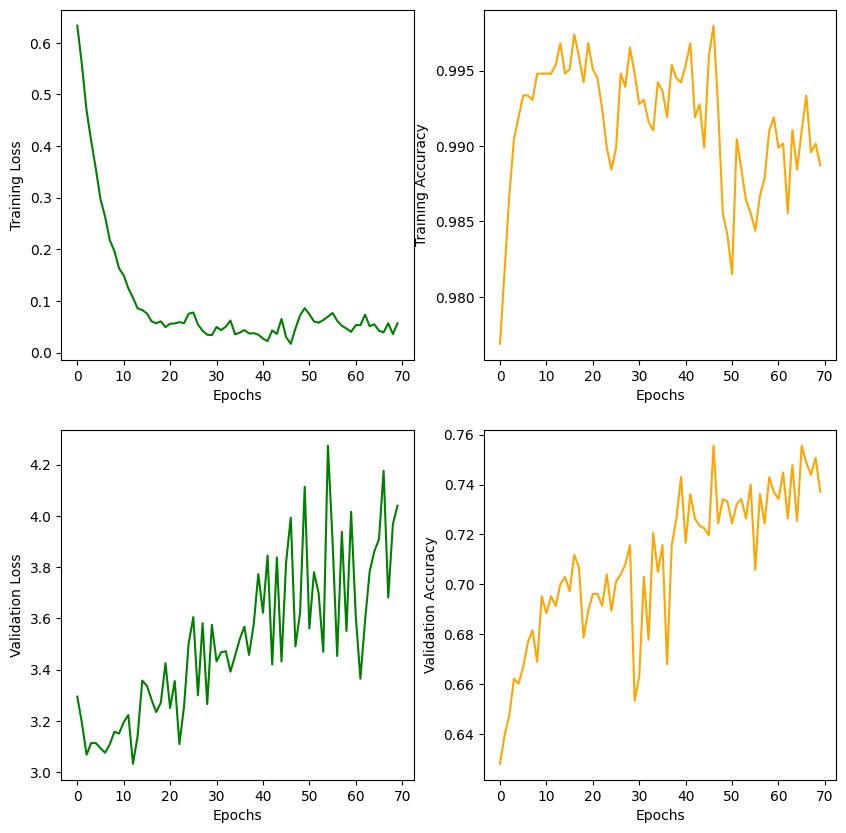

In [99]:
train_loss, train_acc = history.history['loss'], history.history['masked_accuracy']
val_loss, val_acc = history.history['val_loss'], history.history['val_masked_accuracy']

plt.figure(figsize=(10, 10))

plt.subplot (2, 2, 1)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.plot(train_loss, color='green')

plt.subplot (2, 2, 2)
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.plot(train_acc, color='orange')

plt.subplot (2, 2, 3)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.plot(val_loss, color='green')

plt.subplot (2, 2, 4)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.plot(val_acc, color='orange')

plt.show()

# 5. Application

In [100]:
def generate_text(generator_model, tokenizer, input_string):
    # Encoder
    encoder_input_string = text_normalize(input_string)
    encoder_input_sequence = tokenizer.texts_to_sequences([encoder_input_string])
    encoder_input_padded_sequence = pad_sequences(encoder_input_sequence, maxlen=MAX_SEQ_LEN,
                                                  truncating='pre', padding='post')[0]
    encoder_input_padded_sequence = np.expand_dims(encoder_input_padded_sequence, axis=0)

    # Decoder
    decoder_input_string = '<start>'
    decoder_input_sequence = tokenizer.texts_to_sequences([decoder_input_string])
    decoder_input_padded_sequence = pad_sequences(decoder_input_sequence, maxlen=MAX_SEQ_LEN, 
                                                  truncating='pre', padding='post')[0]
    
    start = decoder_input_padded_sequence[0][tf.newaxis]
    end = decoder_input_padded_sequence[1][tf.newaxis]
    decoder_input_padded_sequence = np.expand_dims(decoder_input_padded_sequence, axis=0)

    # Result
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(MAX_SEQ_LEN):
        output = tf.transpose(output_array.stack())
        predictions = generator_model((encoder_input_padded_sequence, output), training=False)
        predictions = predictions[:, -1:, :] #Shape: (batch_size, 1, vocab_size)
        predicted_id = tf.argmax(predictions, axis=-1)
        output_array = output_array.write(i+1, predicted_id[0])
        if predicted_id == end:
            break

    output = tf.transpose(output_array.stack())
    output_tokens = output.numpy()
    text = tokenizer.sequences_to_texts(output_tokens)[0]

    generator_model([decoder_input_padded_sequence, output[:, :-1]], training=False)
    attention_weights = generator_model.decoder.last_attn_scores

    return text, output_tokens, attention_weights


In [101]:
input = "Ngày buồn tháng nhớ năm thương, \nKêu mua nước mắm, mua nhầm nước tương."
response = []

for i in range(10):
    text, tokens, weights = generate_text(transformer, tokenizer, input)
    response.append(text)
    input = text

AttributeError: 'numpy.ndarray' object has no attribute 'texts_to_sequences'

In [102]:
for i in response:
    print(i)